## **Imports**

In [101]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from functools import partial

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    RFE,
    f_regression,
    mutual_info_classif,
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

## **Paths & Global Variables**

In [ ]:
ROOT_PATH = r"C:\Users\mario\OneDrive\Documents\Work\Side Hustles\Kaggle\titanic"
TARGET_VAR = "survived"
COLINEARITY_THRESHOLD = 0.7
ALPHA = 0.05

import sys

sys.path.append(ROOT_PATH)

from titanic.config import PROCESSED_DATA_DIR

## **Reading Data**

In [ ]:
os.chdir(PROCESSED_DATA_DIR)
X_train = pd.read_parquet("X_train.parquet")
y_train = pd.read_parquet("y_train.parquet")
X_train.head(1)

,siblings_spouses,parents_children,num_rooms,age_scaled,age_min_max,fare_log,passenger_class_ord,age_group_ord,title_lcode,cabin_level_2_lcode,embarked_Q,embarked_S,sex_male,cabin_level_1_B,cabin_level_1_C,cabin_level_1_D,cabin_level_1_E,cabin_level_1_F,cabin_level_1_G
passenger_id,,,,,,,,,,,,,,,,,,,
622,1,0,1,0.958818,0.523988,3.980694,1,1,12,28,False,True,True,False,False,True,False,False,False


In [104]:
y_train.head(1)

,survived
passenger_id,
622,True


# **Feature Selection Methods**

## **Filter Methods**

### **Variance Threshold**

In [105]:
X_num = X_train.select_dtypes(include=["int64", "float64", "bool"])

selector = VarianceThreshold(threshold=0)  # 0 is default
selector.fit_transform(X_num)

num_cols = list(X_num.columns[selector.get_support(indices=True)])
var_drop_cols = list(set(X_num.columns) - set(num_cols))

var_drop_cols

[]

### **Correlation**

<Axes: >

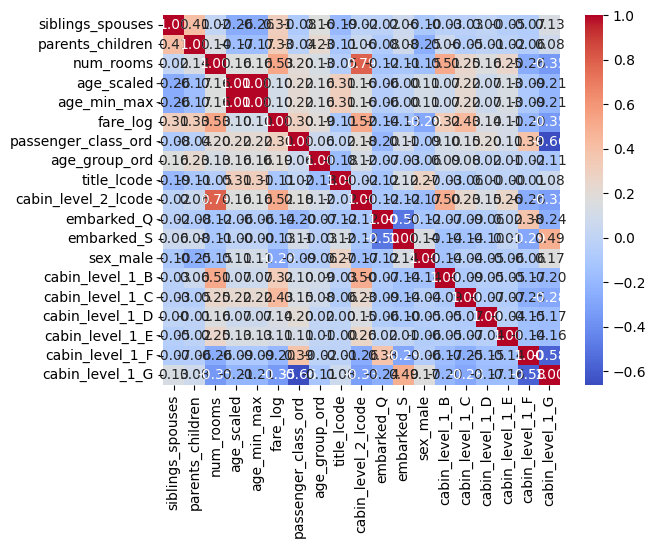

In [106]:
corr_matrix = X_num.corr(method="pearson")
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")

#### **Correlation between Features and Target**

<Axes: >

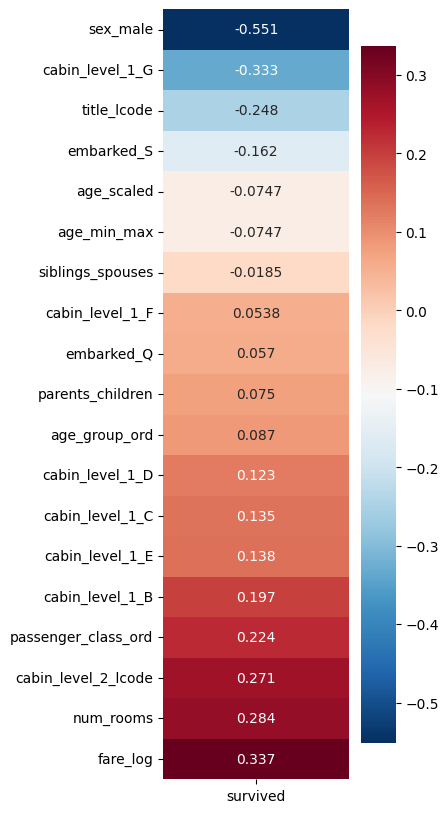

In [107]:
X_y = X_num.copy()
X_y[TARGET_VAR] = y_train

corr_X_y_matrix = X_y.corr()

# Isolate the column corresponding to `exam_score`
corr_target = corr_X_y_matrix[[TARGET_VAR]].drop(labels=[TARGET_VAR])
corr_target.sort_values(TARGET_VAR, inplace=True)

plt.figure(figsize=(3, 10))
sns.heatmap(corr_target, annot=True, fmt=".3", cmap="RdBu_r")

#### **F-Statistic**

In [108]:
f_stat_df = pd.DataFrame(
    f_regression(X_num, y_train)[0], index=X_num.columns, columns=["f_stat"]
)
p_value_df = pd.DataFrame(
    f_regression(X_num, y_train)[1], index=X_num.columns, columns=["p_value"]
)
f_stat_df = pd.concat([f_stat_df, p_value_df], axis=1)
f_stat_df.sort_values("f_stat", inplace=True)
f_stat_df[f_stat_df["p_value"] > ALPHA]

c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,f_stat,p_value
siblings_spouses,0.242373,0.622650
cabin_level_1_F,2.059527,0.151698
embarked_Q,2.307272,0.129216


#### **Correlation between Features**

In [109]:
corr_target.reset_index(inplace=True)
corr_target.columns = ["feature", "corr_target"]
mcol_df = pd.DataFrame()

# Loop over bottom diagonal of correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i):

        # Print variables with high correlation
        if abs(corr_matrix.iloc[i, j]) > COLINEARITY_THRESHOLD:
            var_1 = corr_matrix.columns[i]
            var_2 = corr_matrix.columns[j]
            corr = corr_matrix.iloc[i, j]
            temp_df = pd.DataFrame({"var1": [var_1], "var2": [var_2], "corr": [corr]})
            mcol_df = pd.concat([temp_df, mcol_df])

for var in ["var1", "var2"]:
    mcol_df = pd.merge(
        mcol_df, corr_target, left_on=var, right_on="feature", how="left"
    )
    mcol_df.drop(columns=["feature"], inplace=True)
    mcol_df.rename(columns={"corr_target": f"corr_target_{var[-1]}"}, inplace=True)

mcol_df["col_to_drop"] = mcol_df.apply(
    lambda x: (
        x["var1"] if abs(x["corr_target_1"]) < abs(x["corr_target_2"]) else x["var2"]
    ),
    axis=1,
)
mcol_df

,var1,var2,corr,corr_target_1,corr_target_2,col_to_drop
0,cabin_level_2_lcode,num_rooms,0.788851,0.271087,0.283692,cabin_level_2_lcode
1,age_min_max,age_scaled,1.000000,-0.074727,-0.074727,age_min_max


In [112]:
mcolin_drop_cols = [
    "cabin_level_2_lcode",
    "age_scaled",
]

In [113]:
X_num.drop(columns=var_drop_cols + mcolin_drop_cols, inplace=True)

### **Mutual Information**

In [114]:
discrete_columns = X_num.select_dtypes(include=["int64", "bool"]).columns
discrete_column_numbers = [X_num.columns.get_loc(col) for col in discrete_columns]
discrete_column_numbers

[0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [116]:
mi_class_df = pd.DataFrame(
    mutual_info_classif(
        X_num, y_train, random_state=68, discrete_features=discrete_column_numbers
    ),
    index=X_num.columns,
    columns=["mi_class"],
)
mi_class_df.sort_values("mi_class", inplace=True, ascending=False)
# mi_class_df.reset_index(inplace=True)
mi_class_df

c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,mi_class
title_lcode,0.183759
sex_male,0.155589
fare_log,0.154319
age_min_max,0.082585
cabin_level_1_G,0.058416
passenger_class_ord,0.054234
num_rooms,0.051762
siblings_spouses,0.023029
cabin_level_1_B,0.019105
parents_children,0.016942


In [137]:
score_func = partial(
    mutual_info_classif, discrete_features=discrete_column_numbers, random_state=68
)

# Select top 10 features with the most mutual information
selection = SelectKBest(score_func=score_func, k=10)
selection.fit_transform(X_num, y_train)

kbest_df = mi_class_df.loc[X_num.columns[selection.get_support(indices=True)].to_list()]
kbest_df.sort_values("mi_class", ascending=False)

c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,mi_class
title_lcode,0.183759
sex_male,0.155589
fare_log,0.154319
age_min_max,0.082585
cabin_level_1_G,0.058416
passenger_class_ord,0.054234
num_rooms,0.051762
siblings_spouses,0.023029
cabin_level_1_B,0.019105
parents_children,0.016942


## **Wrapper Methods**

### **Sequential Forward Floating Selection**

In [138]:
K_FEATURES_MAX = 10

In [139]:
log_reg = LogisticRegression(class_weight="balanced", max_iter=400)

# Sequential forward selection
sfs = SFS(
    log_reg,
    k_features=K_FEATURES_MAX,
    forward=True,
    floating=True,
    scoring="accuracy",
    cv=0,
)

# Fit the sequential forward selection model
sfs.fit(X_num, y_train.to_numpy().ravel())

SequentialFeatureSelector(cv=0,
                          estimator=LogisticRegression(class_weight='balanced',
                                                       max_iter=400),
                          floating=True, k_features=(10, 10),
                          scoring='accuracy')

c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlxtend\feature_selection\sequential_feature_selector.py:895: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  std_err = scipy.stats.sem(ary)


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Number of Features', ylabel='Performance'>)

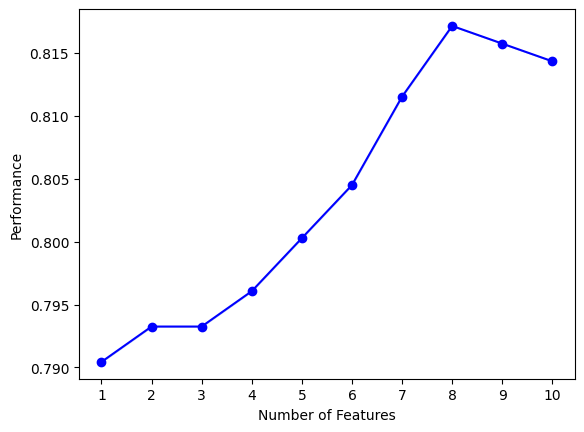

In [140]:
# Plot the accuracy of the model as a function of the number of features
plot_sfs(sfs.get_metric_dict())

In [141]:
# Print a tuple of feature names after 5 features are added
print(sfs.subsets_[1]["feature_names"], sfs.subsets_[1]["avg_score"])
for i in range(1, K_FEATURES_MAX):
    new_feature = set(sfs.subsets_[i + 1]["feature_names"]) - set(
        sfs.subsets_[i]["feature_names"]
    )
    print(new_feature, sfs.subsets_[i + 1]["avg_score"])

('sex_male',) 0.790436005625879
{'siblings_spouses'} 0.7932489451476793
{'age_min_max'} 0.7932489451476793
{'cabin_level_1_E'} 0.7960618846694796
{'passenger_class_ord'} 0.8002812939521801
{'age_group_ord'} 0.8045007032348804
{'cabin_level_1_G'} 0.8115330520393812
{'embarked_S', 'parents_children'} 0.8171589310829818
{'passenger_class_ord'} 0.8157524613220816
{'cabin_level_1_B'} 0.8143459915611815


In [142]:
knn = KNeighborsClassifier(n_neighbors=15)

# Sequential forward selection
sfs = SFS(
    knn,
    k_features=K_FEATURES_MAX,
    forward=True,
    floating=True,
    scoring="accuracy",
    cv=0,
)

# Fit the sequential forward selection model
sfs.fit(X_num, y_train.to_numpy().ravel())

SequentialFeatureSelector(cv=0, estimator=KNeighborsClassifier(n_neighbors=15),
                          floating=True, k_features=(10, 10),
                          scoring='accuracy')

c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlxtend\feature_selection\sequential_feature_selector.py:895: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  std_err = scipy.stats.sem(ary)


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Number of Features', ylabel='Performance'>)

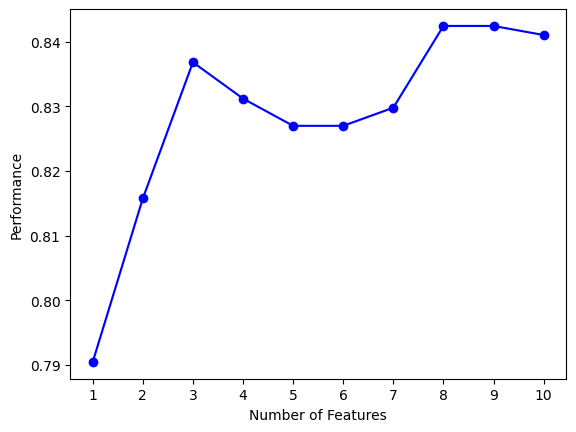

In [143]:
# Plot the accuracy of the model as a function of the number of features
plot_sfs(sfs.get_metric_dict())

In [144]:
# Print a tuple of feature names after 5 features are added
print(sfs.subsets_[1]["feature_names"], sfs.subsets_[1]["avg_score"])
for i in range(1, K_FEATURES_MAX):
    new_feature = set(sfs.subsets_[i + 1]["feature_names"]) - set(
        sfs.subsets_[i]["feature_names"]
    )
    print(new_feature, sfs.subsets_[i + 1]["avg_score"])

('sex_male',) 0.790436005625879
{'fare_log'} 0.8157524613220816
{'cabin_level_1_F'} 0.8368495077355836
{'cabin_level_1_D'} 0.8312236286919831
{'cabin_level_1_B'} 0.8270042194092827
{'cabin_level_1_C'} 0.8270042194092827
{'age_min_max'} 0.829817158931083
{'embarked_Q', 'cabin_level_1_G'} 0.8424753867791842
{'passenger_class_ord', 'age_group_ord'} 0.8424753867791842
{'cabin_level_1_D'} 0.8410689170182841


In [145]:
dtree = DecisionTreeClassifier(max_depth=8, ccp_alpha=0.01, criterion="gini")

# Sequential forward selection
sfs = SFS(
    dtree,
    k_features=K_FEATURES_MAX,
    forward=True,
    floating=False,
    scoring="accuracy",
    cv=0,
)

# Fit the sequential forward selection model
sfs.fit(X_num, y_train.to_numpy().ravel())

SequentialFeatureSelector(cv=0,
                          estimator=DecisionTreeClassifier(ccp_alpha=0.01,
                                                           max_depth=8),
                          k_features=(10, 10), scoring='accuracy')

c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlxtend\feature_selection\sequential_feature_selector.py:895: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  std_err = scipy.stats.sem(ary)


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Number of Features', ylabel='Performance'>)

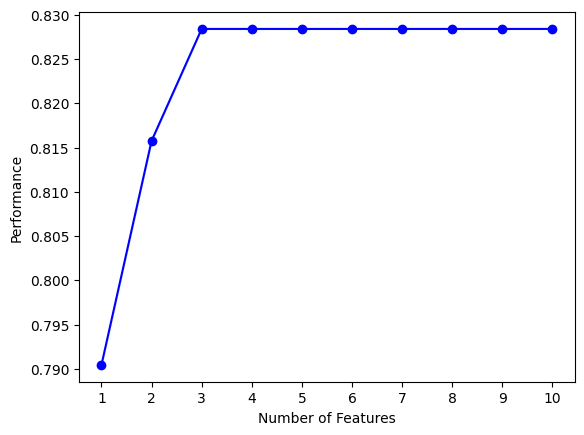

In [146]:
# Plot the accuracy of the model as a function of the number of features
plot_sfs(sfs.get_metric_dict())

In [147]:
# Print a tuple of feature names after 5 features are added
print(sfs.subsets_[1]["feature_names"], sfs.subsets_[1]["avg_score"])
for i in range(1, K_FEATURES_MAX):
    new_feature = set(sfs.subsets_[i + 1]["feature_names"]) - set(
        sfs.subsets_[i]["feature_names"]
    )
    print(new_feature, sfs.subsets_[i + 1]["avg_score"])

('sex_male',) 0.790436005625879
{'cabin_level_1_G'} 0.8157524613220816
{'age_min_max'} 0.8284106891701828
{'siblings_spouses'} 0.8284106891701828
{'parents_children'} 0.8284106891701828
{'num_rooms'} 0.8284106891701828
{'fare_log'} 0.8284106891701828
{'passenger_class_ord'} 0.8284106891701828
{'age_group_ord'} 0.8284106891701828
{'title_lcode'} 0.8284106891701828


### **Sequential Backward Floating Selection**

In [148]:
K_FEATURES_MIN = 2

In [149]:
log_reg = LogisticRegression(class_weight="balanced")

# Sequential forward selection
sfs = SFS(
    log_reg,
    k_features=K_FEATURES_MIN,
    forward=False,
    floating=True,
    scoring="accuracy",
    cv=0,
)

# Fit the sequential forward selection model
sfs.fit(X_num, y_train.to_numpy().ravel())

c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

SequentialFeatureSelector(cv=0,
                          estimator=LogisticRegression(class_weight='balanced'),
                          floating=True, forward=False, k_features=(2, 2),
                          scoring='accuracy')

c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlxtend\feature_selection\sequential_feature_selector.py:895: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  std_err = scipy.stats.sem(ary)


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Number of Features', ylabel='Performance'>)

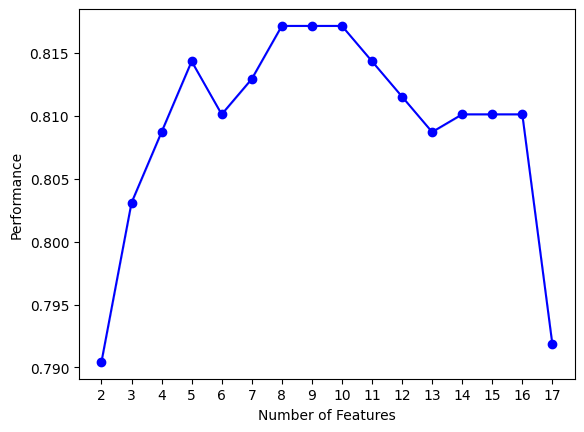

In [150]:
# Plot the accuracy of the model as a function of the number of features
plot_sfs(sfs.get_metric_dict())

In [151]:
# Print a tuple of feature names after 5 features are added
print(
    sfs.subsets_[K_FEATURES_MIN]["feature_names"],
    sfs.subsets_[K_FEATURES_MIN]["avg_score"],
)
for i in range(K_FEATURES_MIN, len(X_num.columns)):
    new_feature = set(sfs.subsets_[i + 1]["feature_names"]) - set(
        sfs.subsets_[i]["feature_names"]
    )
    print(new_feature, sfs.subsets_[i + 1]["avg_score"])

('sex_male', 'cabin_level_1_G') 0.790436005625879
{'title_lcode'} 0.8030942334739803
{'siblings_spouses'} 0.8087201125175809
{'age_min_max'} 0.8143459915611815
{'age_group_ord'} 0.810126582278481
{'cabin_level_1_C'} 0.8129395218002813
{'cabin_level_1_E'} 0.8171589310829818
{'embarked_Q'} 0.8171589310829818
{'passenger_class_ord'} 0.8171589310829818
{'parents_children'} 0.8143459915611815
{'cabin_level_1_D'} 0.8115330520393812
{'num_rooms', 'cabin_level_1_F', 'cabin_level_1_B'} 0.8087201125175809
{'embarked_S'} 0.810126582278481
{'embarked_Q'} 0.810126582278481
{'cabin_level_1_C'} 0.810126582278481
{'fare_log'} 0.7918424753867792


In [152]:
knn = KNeighborsClassifier(n_neighbors=15)

# Sequential forward selection
sfs = SFS(
    knn,
    k_features=K_FEATURES_MIN,
    forward=False,
    floating=True,
    scoring="accuracy",
    cv=0,
)

# Fit the sequential forward selection model
sfs.fit(X_num, y_train.to_numpy().ravel())

SequentialFeatureSelector(cv=0, estimator=KNeighborsClassifier(n_neighbors=15),
                          floating=True, forward=False, k_features=(2, 2),
                          scoring='accuracy')

c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlxtend\feature_selection\sequential_feature_selector.py:895: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  std_err = scipy.stats.sem(ary)


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Number of Features', ylabel='Performance'>)

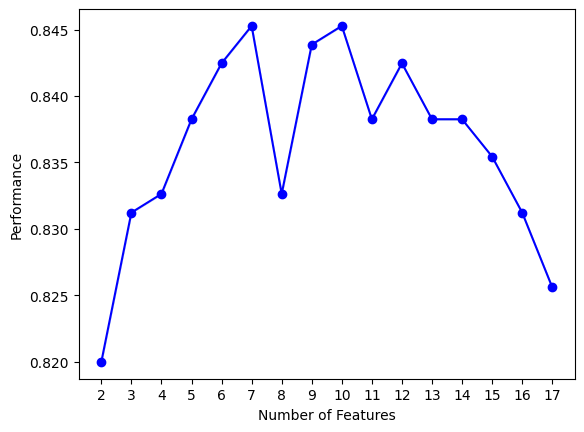

In [153]:
# Plot the accuracy of the model as a function of the number of features
plot_sfs(sfs.get_metric_dict())

In [154]:
# Print a tuple of feature names after 5 features are added
print(
    sfs.subsets_[K_FEATURES_MIN]["feature_names"],
    sfs.subsets_[K_FEATURES_MIN]["avg_score"],
)
for i in range(K_FEATURES_MIN, len(X_num.columns)):
    new_feature = set(sfs.subsets_[i + 1]["feature_names"]) - set(
        sfs.subsets_[i]["feature_names"]
    )
    print(new_feature, sfs.subsets_[i + 1]["avg_score"])

('title_lcode', 'cabin_level_1_G') 0.819971870604782
{'fare_log'} 0.8312236286919831
{'cabin_level_1_B'} 0.8326300984528833
{'siblings_spouses'} 0.8382559774964838
{'parents_children'} 0.8424753867791842
{'sex_male'} 0.8452883263009845
{'cabin_level_1_F'} 0.8326300984528833
{'age_group_ord'} 0.8438818565400844
{'age_min_max'} 0.8452883263009845
{'num_rooms'} 0.8382559774964838
{'cabin_level_1_E'} 0.8424753867791842
{'cabin_level_1_D'} 0.8382559774964838
{'cabin_level_1_C'} 0.8382559774964838
{'embarked_Q'} 0.8354430379746836
{'embarked_S'} 0.8312236286919831
{'passenger_class_ord'} 0.8255977496483825


In [155]:
dtree = DecisionTreeClassifier(max_depth=8, ccp_alpha=0.01, criterion="gini")

# Sequential forward selection
sfs = SFS(
    dtree,
    k_features=K_FEATURES_MIN,
    forward=False,
    floating=True,
    scoring="accuracy",
    cv=0,
)

# Fit the sequential forward selection model
sfs.fit(X_num, y_train.to_numpy().ravel())

SequentialFeatureSelector(cv=0,
                          estimator=DecisionTreeClassifier(ccp_alpha=0.01,
                                                           max_depth=8),
                          floating=True, forward=False, k_features=(2, 2),
                          scoring='accuracy')

c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlxtend\feature_selection\sequential_feature_selector.py:895: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  std_err = scipy.stats.sem(ary)


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Number of Features', ylabel='Performance'>)

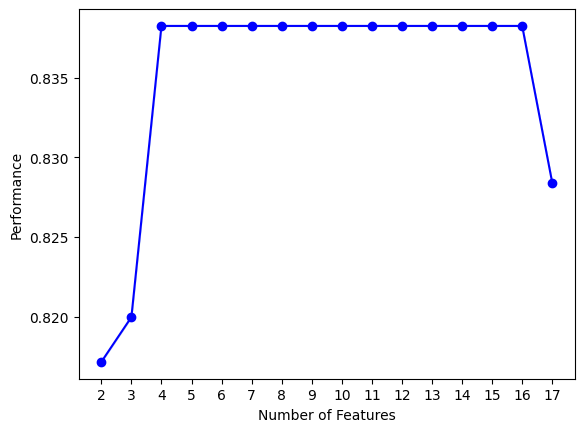

In [156]:
# Plot the accuracy of the model as a function of the number of features
plot_sfs(sfs.get_metric_dict())

In [157]:
# Print a tuple of feature names after 5 features are added
print(
    sfs.subsets_[K_FEATURES_MIN]["feature_names"],
    sfs.subsets_[K_FEATURES_MIN]["avg_score"],
)
for i in range(K_FEATURES_MIN, len(X_num.columns)):
    new_feature = set(sfs.subsets_[i + 1]["feature_names"]) - set(
        sfs.subsets_[i]["feature_names"]
    )
    print(new_feature, sfs.subsets_[i + 1]["avg_score"])

('title_lcode', 'cabin_level_1_G') 0.8171589310829818
{'sex_male'} 0.819971870604782
{'siblings_spouses'} 0.8382559774964838
{'parents_children'} 0.8382559774964838
{'num_rooms'} 0.8382559774964838
{'fare_log'} 0.8382559774964838
{'passenger_class_ord'} 0.8382559774964838
{'age_group_ord'} 0.8382559774964838
{'embarked_Q'} 0.8382559774964838
{'embarked_S'} 0.8382559774964838
{'cabin_level_1_B'} 0.8382559774964838
{'cabin_level_1_C'} 0.8382559774964838
{'cabin_level_1_D'} 0.8382559774964838
{'cabin_level_1_E'} 0.8382559774964838
{'cabin_level_1_F'} 0.8382559774964838
{'age_min_max'} 0.8284106891701828


### **Recursive Feature Elimination**

In [158]:
rfe = RFE(log_reg, n_features_to_select=2)

rfe.fit(X_num, y_train)

rfe_df = pd.DataFrame(rfe.ranking_, index=X_num.columns, columns=["rank"])
rfe_df.sort_values("rank", inplace=True)
rfe_df

c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed w

,rank
sex_male,1
cabin_level_1_G,1
age_min_max,2
num_rooms,3
cabin_level_1_E,4
cabin_level_1_D,5
cabin_level_1_B,6
fare_log,7
siblings_spouses,8
parents_children,9


In [159]:
rfe.score(X_num, y_train)

0.790436005625879

In [163]:
log_reg_features = rfe_df.head(10)
log_reg_features = pd.concat([log_reg_features, kbest_df], axis=1)
log_reg_features

,rank,mi_class
sex_male,1.0,0.155589
cabin_level_1_G,1.0,0.058416
age_min_max,2.0,0.082585
num_rooms,3.0,0.051762
cabin_level_1_E,4.0,NaN
cabin_level_1_D,5.0,NaN
cabin_level_1_B,6.0,0.019105
fare_log,7.0,0.154319
siblings_spouses,8.0,0.023029
parents_children,9.0,0.016942


In [ ]:
rfe = RFE(dtree, n_features_to_select=2)

rfe.fit(X_num, y_train)

rfe_df = pd.DataFrame(rfe.ranking_, index=X_num.columns, columns=["rank"])
rfe_df.sort_values("rank", inplace=True)
rfe_df

,rank
sex_male,1
cabin_level_1_G,1
age_min_max,2
ticket_lcode,3
cabin_level_1_F,4
cabin_level_1_D,5
cabin_level_1_C,6
cabin_level_1_B,7
cabin_level_1_lcode,8
cabin_level_1_E,9


In [ ]:
rfe.score(X_num, y_train)

0.8157524613220816

In [164]:
dtree_features = rfe_df.head(10)
dtree_features = pd.concat([dtree_features, kbest_df], axis=1)
dtree_features

,rank,mi_class
sex_male,1.0,0.155589
cabin_level_1_G,1.0,0.058416
age_min_max,2.0,0.082585
num_rooms,3.0,0.051762
cabin_level_1_E,4.0,NaN
cabin_level_1_D,5.0,NaN
cabin_level_1_B,6.0,0.019105
fare_log,7.0,0.154319
siblings_spouses,8.0,0.023029
parents_children,9.0,0.016942


### **Exhaustive Feature Selection**

In [165]:
# # Perform exhaustive search
# efs = EFS(
#     log_reg,
#     min_features=1,  # Minimum number of features to consider
#     max_features=6,  # Maximum number of features to consider
#     scoring='accuracy',  # Metric to optimize
#     cv=0  # Cross-validation folds
# )

# # Fit selector on training data
# efs.fit(X_num, y_train.to_numpy().ravel())

# # Get best feature subset
# print("Best Feature Indices:", efs.best_idx_)
# print("Best Feature Names:", efs.best_feature_names_)
# print("Best Accuracy Score:", efs.best_score_)

## **Embedded Methods**

# **Export**

In [167]:
os.chdir(PROCESSED_DATA_DIR)
log_reg_features.to_json("log_reg_features.json")
log_reg_features.to_json("knn_features.json")
dtree_features.to_json("dtree_features.json")